In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

# load processed data
sector = 'ZTL'
file_path = glob.glob('../data_preprocessing/processed_features_weather/{}*'.format(sector))
pdf3 = pd.concat(map(pd.read_csv, file_path))
pdf3 = pdf3[pdf3['arr_time']<3500]
pdf3

,Unnamed: 0.1,Unnamed: 0,recTime,time,round-60,round-30,round-15,acId,lat,lon,...,EV_GOA_3600,arr_time,time200,time100,time40,windspeed,winddir,cloudcover,visibility,humidity
0,0,811,1564634536,2019-08-01 00:42:16,0,1,2,DAL2690,34.82167,-83.00944,...,0,483,1564633694,1564634536,1564635019,0.0,0.0,50,16,66.33
1,1,1300,1564634291,2019-08-01 00:38:11,0,1,2,AAL2290,32.45111,-83.06111,...,0,556,1564633501,1564634291,1564634847,0.0,0.0,50,16,66.33
2,2,1964308,1564718625,2019-08-02 00:03:45,0,0,0,DAL2823,32.75667,-86.10000,...,1,552,1564717833,1564718625,1564719177,0.0,0.0,50,16,66.33
3,3,1964550,1564718722,2019-08-02 00:05:22,0,0,0,SWA5823,32.60056,-85.96472,...,1,537,1564717954,1564718722,1564719259,0.0,0.0,50,16,66.33
4,4,1967367,1564718655,2019-08-02 00:04:15,0,0,0,DAL2534,33.47556,-82.44889,...,1,593,1564717436,1564718655,1564719248,0.0,0.0,50,16,66.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,983,2031688,1567136445,2019-08-29 23:40:45,23,47,94,FFT418,34.45222,-86.18333,...,5,571,1567135659,1567136445,1567137016,9.4,20.0,25,13,84.87
984,984,2033108,1567136708,2019-08-29 23:45:08,23,47,95,DAL1054,34.81361,-83.02694,...,4,497,1567135902,1567136708,1567137205,9.4,20.0,25,13,84.87
985,985,2033644,1567136721,2019-08-29 23:45:21,23,47,95,SWA1512,34.35694,-86.22556,...,4,533,1567135947,1567136721,1567137254,9.4,20.0,25,13,84.87
986,986,2033893,1567136901,2019-08-29 23:48:21,23,47,95,DAL1901,34.35972,-86.23611,...,4,497,1567136140,1567136901,1567137398,9.4,20.0,25,13,84.87


## Grid Search with H2o 
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-search-in-python

### GRID SEARCH 1

In [2]:
h2o.init()
hf = h2o.H2OFrame(pdf3)
predictors = ['round-60', 'lat', 'lon', 'alt', 'Dest', 'distance', 'acType', 'groundSpeed', 'distance', 
            '#AC_10mins_ahead', '#AC_10mins_behind', '#AC_30mins_ahead', '#AC_30mins_behind', '#AC_60mins_ahead', '#AC_60mins_behind', 
            'EV_RRT_600', 'EV_RRT_1800', 'EV_RRT_3600', 'EV_LOOP_600', 'EV_LOOP_1800', 'EV_LOOP_3600', 'EV_GOA_600', 'EV_GOA_1800', 'EV_GOA_3600', 'windspeed', 'winddir', 'cloudcover', 'visibility', 'humidity']

response = "arr_time"

valid, train = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1 = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)

gbm_grid1.train(x=predictors, 
                y=response,
                training_frame=train,
                validation_frame=valid,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='rmsle', decreasing=False)

best_model1 = gbm_gridperf1.models[0]

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /home/ypang6/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0o2_hduv
  JVM stdout: /tmp/tmp0o2_hduv/h2o_ypang6_started_from_python.out
  JVM stderr: /tmp/tmp0o2_hduv/h2o_ypang6_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 27 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_g4ic1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.49 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [3]:
gbm_gridperf1

       col_sample_rate  learn_rate  max_depth  sample_rate  \
0                  0.7        0.10        8.0          1.0   
1                  0.7        0.10        7.0          1.0   
2                  0.6        0.10       11.0          1.0   
3                  0.7        0.10       10.0          1.0   
4                  0.6        0.10        8.0          1.0   
.. ..              ...         ...        ...          ...   
91                 0.8        0.05       11.0          0.8   
92                 0.8        0.10       12.0          0.8   
93                 0.8        0.05        7.0          0.8   
94                 0.8        0.05       12.0          0.8   
95                 0.6        0.05        8.0          0.8   

             model_ids     rmsle  
0   gbm_grid1_model_63  0.094470  
1   gbm_grid1_model_55  0.094681  
2   gbm_grid1_model_86  0.094957  
3   gbm_grid1_model_79  0.095157  
4   gbm_grid1_model_62  0.095235  
..                 ...       ...  
91  gbm_gr

In [4]:
perf1 = best_model1.model_performance(valid)
perf1


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 6403.641177530449
RMSE: 80.02275412362691
MAE: 36.73908120640685
RMSLE: 0.09446991184026157
Mean Residual Deviance: 6403.641177530449


In [5]:
valid.shape

(5673, 39)

### Draw Model Predictions

#### Training Set

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


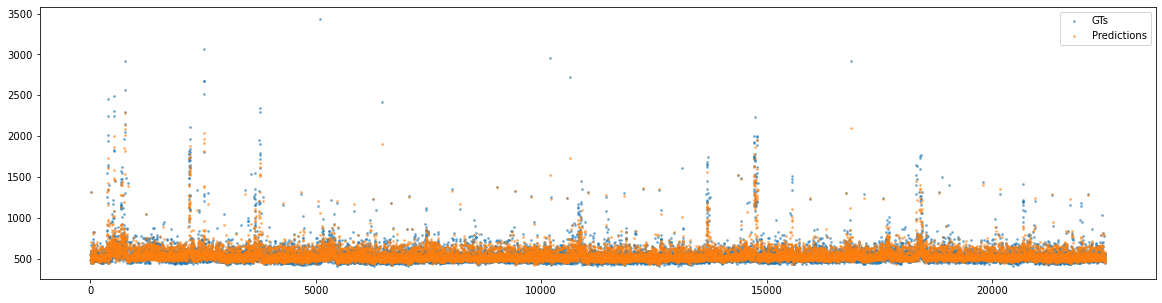

In [6]:
# retrieve the model performance
pred = best_model1.predict(train)
validpd = h2o.as_list(train)

fig, ax = plt.subplots(figsize=(20, 5))
x = np.arange(len(validpd))
plt.scatter(x, validpd['arr_time'].tolist(), s=3, alpha=0.5, label='GTs')
predpd = h2o.as_list(pred)
plt.scatter(x, predpd['predict'].tolist(), s=3, alpha=0.5, label='Predictions')

plt.legend()
plt.savefig('result_RF_training', dpi=300)

#### Validation Set

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


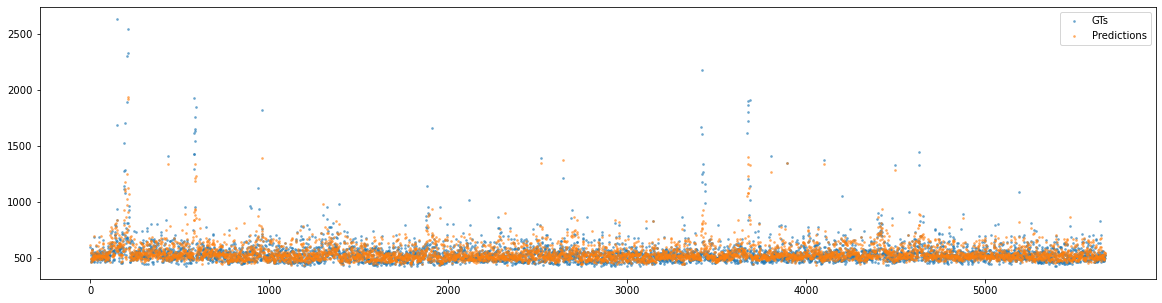

In [7]:
# retrieve the model performance
pred1 = best_model1.predict(valid)
validpd1 = h2o.as_list(valid)
predpd1 = h2o.as_list(pred1)

fig, ax = plt.subplots(figsize=(20, 5))
x = np.arange(len(validpd1))
plt.scatter(x, validpd1['arr_time'].tolist(), s=3, alpha=0.5, label='GTs')
plt.scatter(x, predpd1['predict'].tolist(), s=3, alpha=0.5, label='Predictions')

plt.legend()
plt.savefig('result_RF_validation', dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


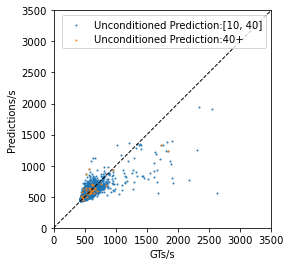

In [8]:
# validation on EV_LOOP_600>10
valid1_10_40 = valid[(valid['EV_LOOP_600']>10)&valid['EV_LOOP_600']<40]
pred1_10_40 = best_model1.predict(valid1_10_40)
validpd1_10_40 = h2o.as_list(valid1_10_40)
predpd1_10_40 = h2o.as_list(pred1_10_40)

plt.scatter(validpd1_10_40['arr_time'].tolist(), predpd1_10_40['predict'].tolist(),  marker = '.', s=5, alpha=0.8, label='Unconditioned Prediction:[10, 40]')

# validation on EV_LOOP_600
valid1_40 = valid[valid['EV_LOOP_600']>=40]
pred1_40 = best_model1.predict(valid1_40)
validpd1_40 = h2o.as_list(valid1_40)
predpd1_40 = h2o.as_list(pred1_40)

plt.scatter(validpd1_40['arr_time'].tolist(), predpd1_40['predict'].tolist(),  marker = '.', s=5, alpha=0.8, label='Unconditioned Prediction:40+')


plt.xlabel('GTs/s')
plt.ylabel('Predictions/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

# EV_LOOP < 10

In [9]:
# h2o.shutdown() 
h2o.init()

pdf3_conditional_0 = pdf3[pdf3['EV_LOOP_600']<10]

hf = h2o.H2OFrame(pdf3_conditional_0)

valid0, train0 = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1_conditonal_0 = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}
                
# Train and validate a cartesian grid of GBMs
gbm_grid1_conditonal_0 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid0',
                          hyper_params=gbm_params1_conditonal_0,
                          )

gbm_grid1_conditonal_0.train(x=predictors, 
                y=response,
                training_frame=train0,
                validation_frame=valid0,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1_conditonal_0 = gbm_grid1_conditonal_0.get_grid(sort_by='mae', decreasing=False)

best_model1_conditonal_0 = gbm_gridperf1_conditonal_0.models[0]

perf1_conditonal_0 = best_model1_conditonal_0.model_performance(valid0)
perf1_conditonal_0


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 mins 46 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 27 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_g4ic1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.35 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 5640.001403880172
RMSE: 75.09994276882088
MAE: 33.365806262354106
RMSLE: 0.09242936620986902
Mean Residual Deviance: 5640.001403880172


In [10]:
valid0.shape

(4878, 39)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


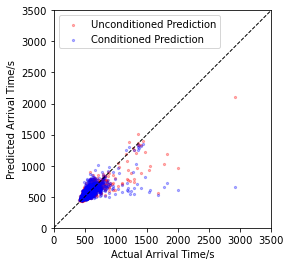

In [11]:
valid10 = valid0

pred1_10 = best_model1.predict(valid10)
pred0_10 = best_model1_conditonal_0.predict(valid10)

validpd1_10 = h2o.as_list(valid10)
predpd1_10 = h2o.as_list(pred1_10)
predpd0_10 = h2o.as_list(pred0_10)

plt.scatter(validpd1_10['arr_time'].tolist(), predpd1_10['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')
plt.scatter(validpd1_10['arr_time'].tolist(), predpd0_10['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='blue', label='Conditioned Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()
plt.savefig('unconditional_prediction_10', dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


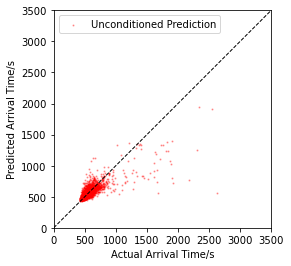

In [12]:
# retrieve the model performance
pred1 = best_model1.predict(valid)
validpd1 = h2o.as_list(valid)
predpd1 = h2o.as_list(pred1)

plt.scatter(validpd1['arr_time'].tolist(), predpd1['predict'].tolist(),  marker = '.', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()
plt.savefig('unconditional_prediction', dpi=300)

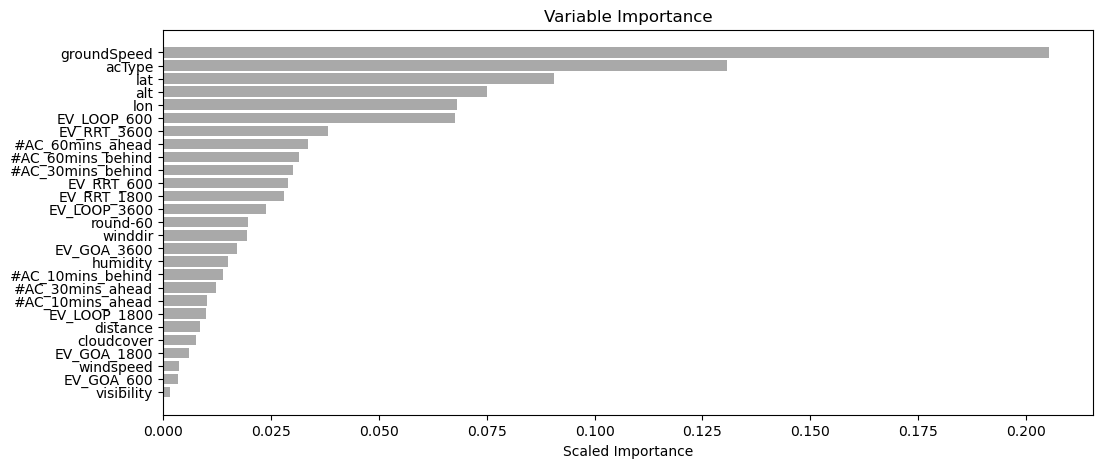

In [13]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 5))
variables = best_model1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model1._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
fig.savefig('VI_unconditional', dpi=300)
plt.show()


## Conditional ML Predictor

In [14]:
pdf3

,Unnamed: 0.1,Unnamed: 0,recTime,time,round-60,round-30,round-15,acId,lat,lon,...,EV_GOA_3600,arr_time,time200,time100,time40,windspeed,winddir,cloudcover,visibility,humidity
0,0,811,1564634536,2019-08-01 00:42:16,0,1,2,DAL2690,34.82167,-83.00944,...,0,483,1564633694,1564634536,1564635019,0.0,0.0,50,16,66.33
1,1,1300,1564634291,2019-08-01 00:38:11,0,1,2,AAL2290,32.45111,-83.06111,...,0,556,1564633501,1564634291,1564634847,0.0,0.0,50,16,66.33
2,2,1964308,1564718625,2019-08-02 00:03:45,0,0,0,DAL2823,32.75667,-86.10000,...,1,552,1564717833,1564718625,1564719177,0.0,0.0,50,16,66.33
3,3,1964550,1564718722,2019-08-02 00:05:22,0,0,0,SWA5823,32.60056,-85.96472,...,1,537,1564717954,1564718722,1564719259,0.0,0.0,50,16,66.33
4,4,1967367,1564718655,2019-08-02 00:04:15,0,0,0,DAL2534,33.47556,-82.44889,...,1,593,1564717436,1564718655,1564719248,0.0,0.0,50,16,66.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,983,2031688,1567136445,2019-08-29 23:40:45,23,47,94,FFT418,34.45222,-86.18333,...,5,571,1567135659,1567136445,1567137016,9.4,20.0,25,13,84.87
984,984,2033108,1567136708,2019-08-29 23:45:08,23,47,95,DAL1054,34.81361,-83.02694,...,4,497,1567135902,1567136708,1567137205,9.4,20.0,25,13,84.87
985,985,2033644,1567136721,2019-08-29 23:45:21,23,47,95,SWA1512,34.35694,-86.22556,...,4,533,1567135947,1567136721,1567137254,9.4,20.0,25,13,84.87
986,986,2033893,1567136901,2019-08-29 23:48:21,23,47,95,DAL1901,34.35972,-86.23611,...,4,497,1567136140,1567136901,1567137398,9.4,20.0,25,13,84.87


Average EV_LOOP_600 for arr_time threshold [400, 600]: 4.490719689140589
Average EV_LOOP_1800 for arr_time threshold [400, 600]: 13.565086189078583
Average EV_LOOP_3600 for arr_time threshold [400, 600]: 27.35108098052995
Average EV_LOOP_600 for arr_time threshold [600, 800]: 6.075635276532138
Average EV_LOOP_1800 for arr_time threshold [600, 800]: 18.40627802690583
Average EV_LOOP_3600 for arr_time threshold [600, 800]: 36.49985052316891
Average EV_LOOP_600 for arr_time threshold [800, 1000]: 8.109311740890687
Average EV_LOOP_1800 for arr_time threshold [800, 1000]: 21.25506072874494
Average EV_LOOP_3600 for arr_time threshold [800, 1000]: 38.16194331983806
Average EV_LOOP_600 for arr_time threshold [1000, 1200]: 13.716981132075471
Average EV_LOOP_1800 for arr_time threshold [1000, 1200]: 29.245283018867923
Average EV_LOOP_3600 for arr_time threshold [1000, 1200]: 47.9622641509434
Average EV_LOOP_600 for arr_time threshold [1200, 1400]: 10.863636363636363
Average EV_LOOP_1800 for arr_

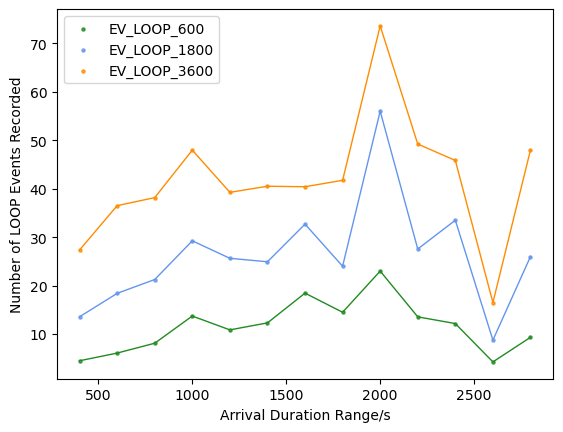

In [15]:
ts =  np.arange(400, 3200, 200).tolist()
avg600, avg1800, avg3600 = [], [], []
for idx in range(len(ts)-1):
    avg600.append(pdf3[(pdf3['arr_time']>ts[idx]) & (pdf3['arr_time']<ts[idx+1])]['EV_LOOP_600'].mean())
    print(f'Average EV_LOOP_600 for arr_time threshold [{ts[idx]}, {ts[idx+1]}]: {avg600[-1]}')

    avg1800.append(pdf3[(pdf3['arr_time']>ts[idx]) & (pdf3['arr_time']<ts[idx+1])]['EV_LOOP_1800'].mean())
    print(f'Average EV_LOOP_1800 for arr_time threshold [{ts[idx]}, {ts[idx+1]}]: {avg1800[-1]}')

    avg3600.append(pdf3[(pdf3['arr_time']>ts[idx]) & (pdf3['arr_time']<ts[idx+1])]['EV_LOOP_3600'].mean())
    print(f'Average EV_LOOP_3600 for arr_time threshold [{ts[idx]}, {ts[idx+1]}]: {avg3600[-1]}')

plt.scatter(ts[:-1], avg600, s=5, alpha=0.8, label='EV_LOOP_600', color='forestgreen')
plt.scatter(ts[:-1], avg1800, s=5, alpha=0.8, label='EV_LOOP_1800', color='cornflowerblue')
plt.scatter(ts[:-1], avg3600, s=5, alpha=0.8, label='EV_LOOP_3600', color='darkorange')

plt.plot(ts[:-1], avg600, linewidth=1, color='forestgreen')
plt.plot(ts[:-1], avg1800, linewidth=1, color='cornflowerblue')
plt.plot(ts[:-1], avg3600, linewidth=1, color='darkorange')

plt.ylabel('Number of LOOP Events Recorded')
plt.xlabel('Arrival Duration Range/s')
plt.legend()
plt.savefig('event_hist.png', dpi=300)

Average arr_time for EV_LOOP_600 threshold [0, 10]: 541.6172998377441
Average arr_time for EV_LOOP_1800 threshold [0, 10]: 538.6208287125718
Average arr_time for EV_LOOP_3600 threshold [0, 10]: 538.6072607260726
Average arr_time for EV_LOOP_600 threshold [10, 20]: 571.85500427716
Average arr_time for EV_LOOP_1800 threshold [10, 20]: 544.850350275749
Average arr_time for EV_LOOP_3600 threshold [10, 20]: 543.3873890532544
Average arr_time for EV_LOOP_600 threshold [20, 30]: 668.7136150234742
Average arr_time for EV_LOOP_1800 threshold [20, 30]: 551.3408941485865
Average arr_time for EV_LOOP_3600 threshold [20, 30]: 546.8388388388388
Average arr_time for EV_LOOP_600 threshold [30, 40]: 624.4263157894737
Average arr_time for EV_LOOP_1800 threshold [30, 40]: 568.8066491688539
Average arr_time for EV_LOOP_3600 threshold [30, 40]: 548.9201367308888
Average arr_time for EV_LOOP_600 threshold [40, 50]: 667.237037037037
Average arr_time for EV_LOOP_1800 threshold [40, 50]: 582.6654343807763
Aver

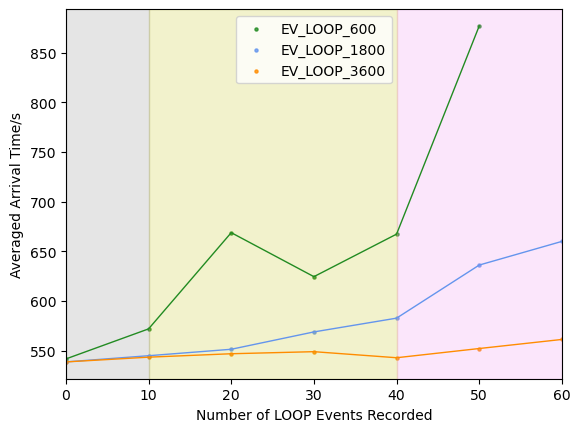

In [16]:
ts =  np.arange(0, 80, 10).tolist()
avg600, avg1800, avg3600 = [], [], []
for idx in range(len(ts)-1):
    avg600.append(pdf3[(pdf3['EV_LOOP_600']>ts[idx]) & (pdf3['EV_LOOP_600']<ts[idx+1])]['arr_time'].mean())
    print(f'Average arr_time for EV_LOOP_600 threshold [{ts[idx]}, {ts[idx+1]}]: {avg600[-1]}')

    avg1800.append(pdf3[(pdf3['EV_LOOP_1800']>ts[idx]) & (pdf3['EV_LOOP_1800']<ts[idx+1])]['arr_time'].mean())
    print(f'Average arr_time for EV_LOOP_1800 threshold [{ts[idx]}, {ts[idx+1]}]: {avg1800[-1]}')

    avg3600.append(pdf3[(pdf3['EV_LOOP_3600']>ts[idx]) & (pdf3['EV_LOOP_3600']<ts[idx+1])]['arr_time'].mean())
    print(f'Average arr_time for EV_LOOP_3600 threshold [{ts[idx]}, {ts[idx+1]}]: {avg3600[-1]}')
fig, ax = plt.subplots()

plt.scatter(ts[:-1], avg600, s=5, alpha=0.8, label='EV_LOOP_600', color='forestgreen')
plt.scatter(ts[:-1], avg1800, s=5, alpha=0.8, label='EV_LOOP_1800', color='cornflowerblue')
plt.scatter(ts[:-1], avg3600, s=5, alpha=0.8, label='EV_LOOP_3600', color='darkorange')

plt.plot(ts[:-1], avg600, linewidth=1, color='forestgreen')
plt.plot(ts[:-1], avg1800, linewidth=1, color='cornflowerblue')
plt.plot(ts[:-1], avg3600, linewidth=1, color='darkorange')

ax.axvspan(10, 40, alpha=0.2, color='y')
ax.axvspan(40, 60, alpha=0.2, color='violet')
ax.axvspan(0, 10, alpha=0.2, color='grey')

#plt.axvline(x=10, ymin=0, ymax=1000, c='y')

plt.xlim(0, 60)
plt.ylabel('Averaged Arrival Time/s')
plt.xlabel('Number of LOOP Events Recorded')
plt.legend()
plt.savefig('arr_time_hist.png', dpi=300)

# 10 < EV_LOOP < 40

In [17]:
pdf3_conditional = pdf3[(pdf3['EV_LOOP_600']>10)&(pdf3['EV_LOOP_600']<40)]

In [18]:
pdf3_conditional

,Unnamed: 0.1,Unnamed: 0,recTime,time,round-60,round-30,round-15,acId,lat,lon,...,EV_GOA_3600,arr_time,time200,time100,time40,windspeed,winddir,cloudcover,visibility,humidity
326,326,552579,1564671279,2019-08-01 10:54:39,10,21,43,SWA2357,34.82583,-83.01250,...,1,511,1564670450,1564671279,1564671790,11.2,100.0,88,16,68.20
340,340,598367,1564672211,2019-08-01 11:10:11,11,22,44,NKS404,32.45500,-83.05528,...,3,524,1564671457,1564672211,1564672735,7.6,100.0,25,16,66.33
342,342,610528,1564672613,2019-08-01 11:16:53,11,22,45,DAL1113,33.43278,-82.45972,...,3,633,1564671712,1564672613,1564673246,7.6,100.0,25,16,66.33
344,344,613124,1564672583,2019-08-01 11:16:23,11,22,45,DAL2420,32.45778,-83.05833,...,3,537,1564671805,1564672583,1564673120,7.6,100.0,25,16,66.33
345,345,617007,1564672969,2019-08-01 11:22:49,11,22,45,DAL2609,34.68389,-82.86778,...,2,514,1564671963,1564672969,1564673483,7.6,100.0,25,16,66.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,700,1463111,1567115421,2019-08-29 17:50:21,17,35,71,DAL1556,34.40583,-86.19611,...,6,473,1567114683,1567115421,1567115894,22.3,360.0,88,16,49.40
707,707,1660326,1567115167,2019-08-29 17:46:07,17,35,71,DAL2299,34.81750,-83.02111,...,6,518,1567114362,1567115167,1567115685,22.3,360.0,88,16,49.40
967,967,1950472,1567131362,2019-08-29 22:16:02,22,44,89,ASH6108,32.60361,-85.95944,...,4,549,1567130607,1567131362,1567131911,20.5,200.0,50,11,87.47
968,968,1950980,1567131476,2019-08-29 22:17:56,22,44,89,DAL2580,34.35361,-86.21306,...,4,486,1567130704,1567131476,1567131962,20.5,200.0,50,11,87.47


In [19]:
# h2o.cluster().shutdown()
h2o.init()
hf = h2o.H2OFrame(pdf3_conditional)

valid2, train2 = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1_conditonal = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}

# Train and validate a cartesian grid of GBMs
gbm_grid1_conditonal = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params1_conditonal,
                          )

gbm_grid1_conditonal.train(x=predictors, 
                y=response,
                training_frame=train2,
                validation_frame=valid2,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1_conditonal = gbm_grid1_conditonal.get_grid(sort_by='mae', decreasing=False)

best_model1_conditonal = gbm_gridperf1_conditonal.models[0]

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 mins 04 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 27 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_g4ic1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.21 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [20]:
gbm_gridperf1_conditonal

       col_sample_rate  learn_rate  max_depth  sample_rate  \
0                  0.8        0.05       10.0          1.0   
1                  0.8        0.05       12.0          1.0   
2                  0.8        0.05       11.0          1.0   
3                  0.7        0.05       11.0          1.0   
4                  0.6        0.05       12.0          1.0   
.. ..              ...         ...        ...          ...   
91                 0.6        0.10        8.0          0.8   
92                 0.5        0.10        7.0          0.8   
93                 0.8        0.10       12.0          0.8   
94                 0.6        0.10        7.0          0.8   
95                 0.8        0.10        7.0          0.8   

             model_ids        mae  
0   gbm_grid2_model_76  54.991407  
1   gbm_grid2_model_92  55.127402  
2   gbm_grid2_model_84  55.300210  
3   gbm_grid2_model_83  55.690121  
4   gbm_grid2_model_90  55.729561  
..                 ...        ...  
91 

In [21]:
valid2.shape

(637, 39)

In [22]:
perf1_conditonal = best_model1_conditonal.model_performance(valid2)
perf1_conditonal


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 12040.280606854798
RMSE: 109.72821244718607
MAE: 54.99140663836098
RMSLE: 0.13044535875604085
Mean Residual Deviance: 12040.280606854798


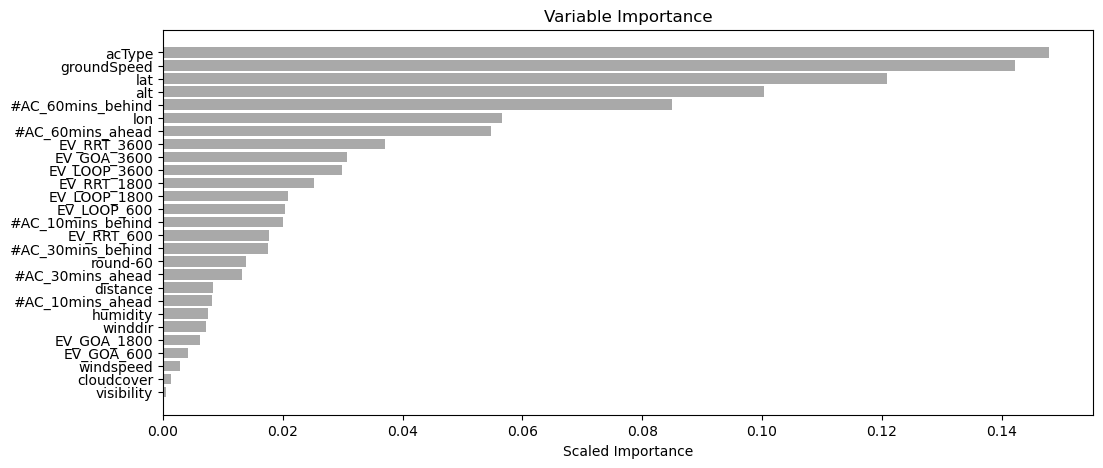

In [23]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,5))
variables = best_model1_conditonal._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model1_conditonal._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_conditional', dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


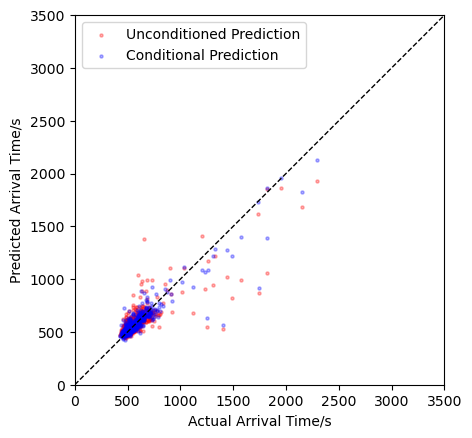

In [24]:
# retrieve the model performance
pred_conditional2 = best_model1_conditonal.predict(valid2)
validpd2 = h2o.as_list(valid2)
predpd2 = h2o.as_list(pred_conditional2)

pred1_10_40 = best_model1.predict(valid2)
predpd1_10_40 = h2o.as_list(pred1_10_40)

plt.scatter(validpd2['arr_time'].tolist(), predpd2['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')
plt.scatter(validpd2['arr_time'].tolist(), predpd1_10_40['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='blue', label='Conditional Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)

plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

plt.savefig('compare_filter_ev_600_loop.png', dpi=300)

### filter EV_LOOP_600 > 40


In [25]:
pdf3_conditional_2 = pdf3[pdf3['EV_LOOP_600']>40]
# h2o.cluster().shutdown()
h2o.init()
hf = h2o.H2OFrame(pdf3_conditional_2)


valid3, train3 = hf.split_frame(ratios = [.2], seed = 1234)

# Grid Search Model
gbm_params1_conditonal_2 = {'learn_rate': [0.05, 0.1],
                'max_depth': [7, 8, 9, 10, 11, 12],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 0.6, 0.7, 0.8]}
                
# Train and validate a cartesian grid of GBMs
gbm_grid1_conditonal_2 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid3',
                          hyper_params=gbm_params1_conditonal_2,
                          )

gbm_grid1_conditonal_2.train(x=predictors, 
                y=response,
                training_frame=train3,
                validation_frame=valid3,
                ntrees=100,
                seed=1234)

# show best grid
gbm_gridperf1_conditonal_2 = gbm_grid1_conditonal_2.get_grid(sort_by='mae', decreasing=False)

best_model1_conditonal_2 = gbm_gridperf1_conditonal_2.models[0]

perf1_conditonal_2 = best_model1_conditonal_2.model_performance(valid3)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 mins 18 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 27 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_g4ic1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.13 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [26]:
perf1_conditonal_2


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 36752.11884701025
RMSE: 191.70842142955078
MAE: 123.22909668983591
RMSLE: 0.21386517147499925
Mean Residual Deviance: 36752.11884701025


In [27]:
valid3.shape

(38, 39)

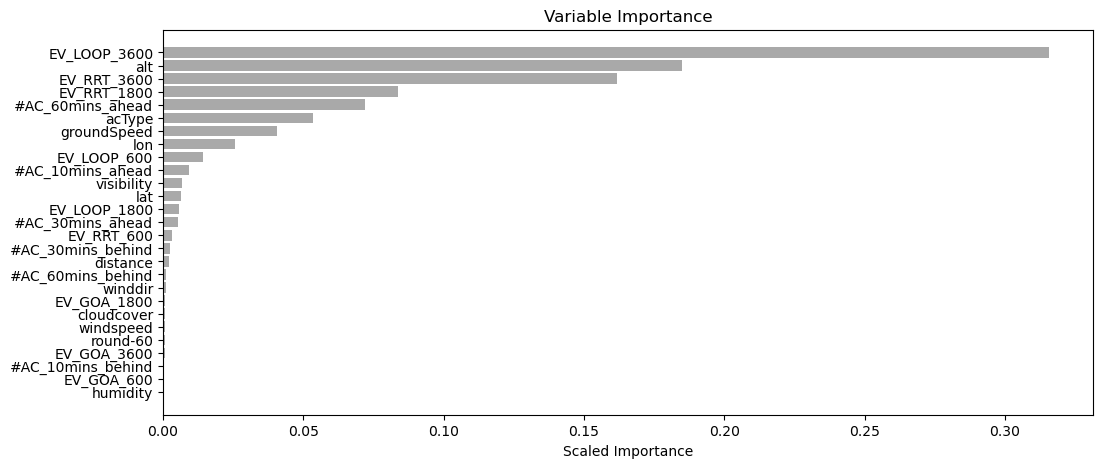

In [28]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,5))
variables = best_model1_conditonal_2._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model1_conditonal_2._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_conditional_2',dpi=300)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


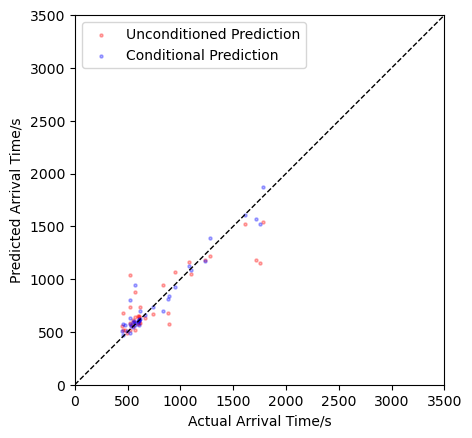

In [29]:
# retrieve the model performance
pred3 = gbm_gridperf1_conditonal_2.models[0].predict(valid3)
validpd3 = h2o.as_list(valid3)
predpd3 = h2o.as_list(pred3)

pred_40 = gbm_gridperf1.models[0].predict(valid3)
predpd_40 = h2o.as_list(pred_40)

plt.scatter(validpd3['arr_time'].tolist(), predpd3['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='red', label='Unconditioned Prediction')
plt.scatter(validpd3['arr_time'].tolist(), predpd_40['predict'].tolist(),  marker = 'o', s=5, alpha=0.3, color='blue', label='Conditional Prediction')

plt.xlabel('Actual Arrival Time/s')
plt.ylabel('Predicted Arrival Time/s')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

plt.savefig('compare_filter_ev_600_loop_40.png', dpi=300)

# Averaged Conditional Prediction Results

In [30]:
# round-30
# re2 = {'MSE': 27999.627953152103,
# 'RMSE': 167.33089360053063,
# 'MAE': 66.33624418696985,
# 'RMSLE': 0.15108980847872783,
#     }

# re3 = {
#     'MSE': 27082.404731153543,
# 'RMSE': 164.56732583096058,
# 'MAE': 109.57216649418756,
# 'RMSLE': 0.189383790894846,
# }

# re1 = {'MSE': 6749.333952660869,
# 'RMSE': 82.15433009075583,
# 'MAE': 34.16417732212681,
# 'RMSLE': 0.09517193967977966}


# round-15
re2 = {'MSE': 12040.280606854798,
    'RMSE': 109.72821244718607,
    'MAE': 54.99140663836098,
    'RMSLE': 0.13044535875604085
    }

re3 = {
    'MSE': 36752.11884701025,
    'RMSE': 191.70842142955078,
    'MAE': 123.22909668983591,
    'RMSLE': 0.21386517147499925
}

re1 = {'MSE': 5640.001403880172,
'RMSE': 75.09994276882088,
'MAE': 33.365806262354106,
'RMSLE': 0.09242936620986902}


In [31]:
for key in ['RMSE', 'MAE', 'RMSLE']:
    re = re2[key]*valid2.shape[0]+re1[key]*valid0.shape[0]+re3[key]*valid3.shape[0]
    print(f'The Averaged {key} for Conditional Predictor is {re/valid.shape[0]}')

The Averaged RMSE for Conditional Predictor is 78.18073544323792
The Averaged MAE for Conditional Predictor is 35.6902229244867
The Averaged RMSLE for Conditional Predictor is 0.09555632265386728


## Quantile Regression pf GBM
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

In [40]:
h2o.init()
hf = h2o.H2OFrame(pdf3)

valid, train = hf.split_frame(ratios = [.2], seed = 1234)

best_model_down = H2OGradientBoostingEstimator(distribution = "quantile", 
                                               #quantile_alpha = 0.164, 
                                               quantile_alpha = 0.80, 
                                               seed = 1234,
                                               col_sample_rate=0.7,
                                               learn_rate=0.1,
                                               max_depth=8, 
                                               sample_rate=1.0)
best_model_down.train(x = predictors,
                      y = response,
                      training_frame = train,
                      validation_frame = valid)

pred_low = best_model_down.predict(valid)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,41 mins 29 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 year and 27 days !!!
H2O_cluster_name:,H2O_from_python_ypang6_g4ic1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.10 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/ypang6/anaconda3/lib/python3.8/site-packages/h2o/estimators/estimator_base.py:208: RuntimeWarning: Dropping bad and constant columns: [Dest]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [41]:
best_model_down.model_performance(valid)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 9051.22032584521
RMSE: 95.13790162624574
MAE: 44.845235762768695
RMSLE: 0.11558849961528375
Mean Residual Deviance: 16.171745422004896


In [42]:
best_model_up = H2OGradientBoostingEstimator(distribution = "quantile", 
                                             quantile_alpha = 0.7, 
                                            #  quantile_alpha = 0.837, 
                                             seed = 1234,
                                             col_sample_rate=0.6,
                                             learn_rate=0.05,
                                             max_depth=10, 
                                             sample_rate=1.0)
best_model_up.train(x = predictors,
                    y = response,
                    training_frame = train,
                    validation_frame = valid)

pred_up = best_model_up.predict(valid)

gbm Model Build progress: |

██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


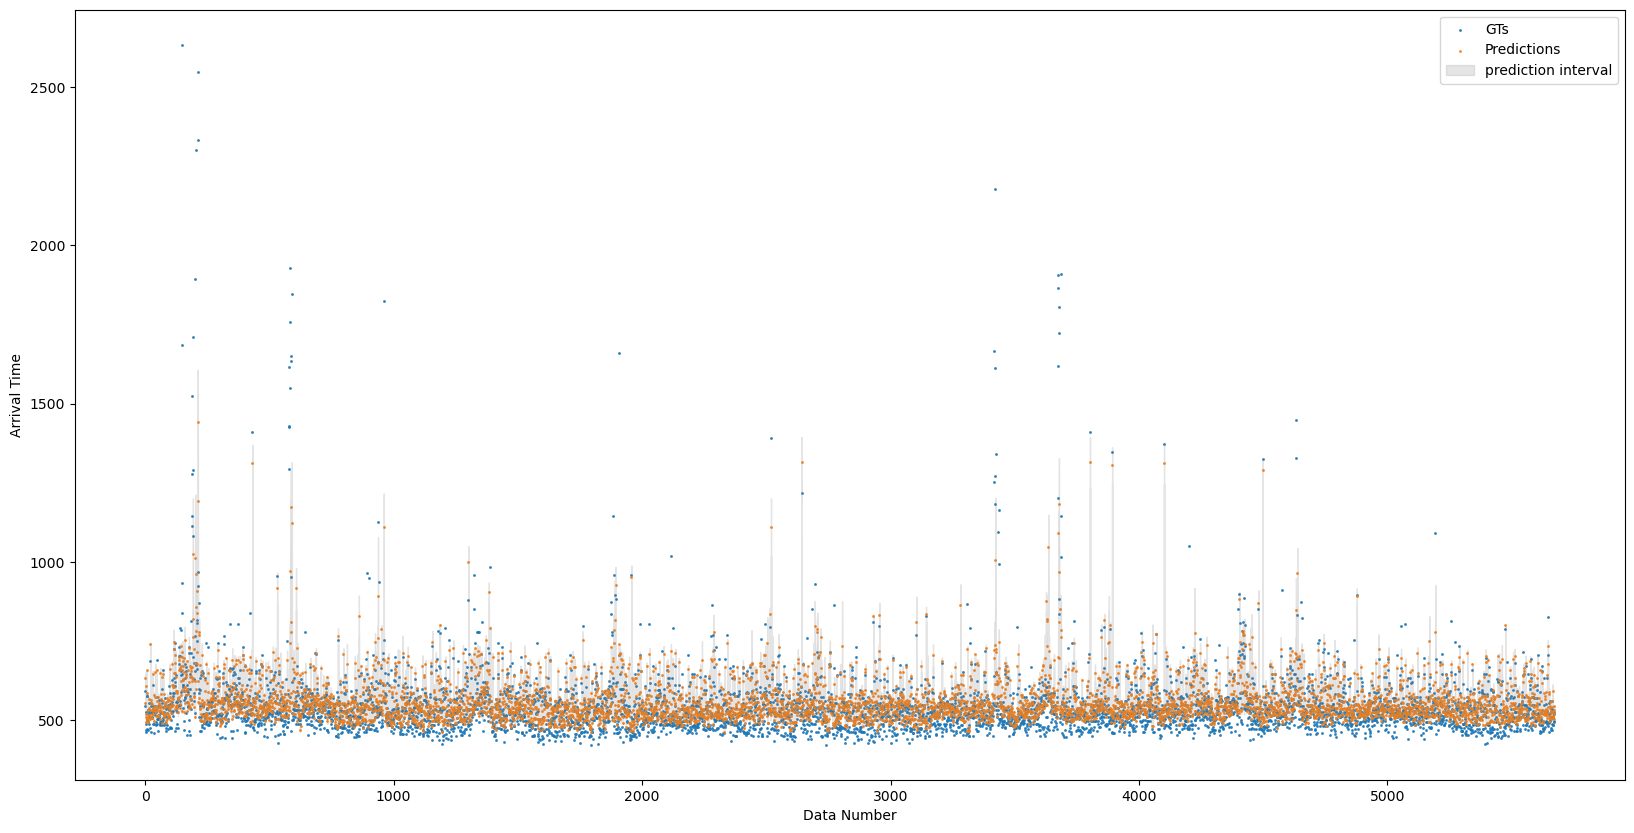

In [43]:
fig, ax= plt.subplots(figsize=(20, 10))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))

_ = range(valid.shape[0])
plt.scatter(_, validpd['arr_time'].tolist(), marker = '.', label='GTs', s=5, alpha=0.8)

err_down = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_down+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_down - pred_m, err_up-pred_m]
plt.scatter(_, pred_m, marker = '.', label='Predictions', s=5, alpha=0.8)

plt.fill_between(x, err_down, err_up, color='gray', alpha=0.2, label='prediction interval')
plt.legend()
plt.ylabel('Arrival Time')
plt.xlabel('Data Number')
fig.savefig('MLPrediction', dpi=300)

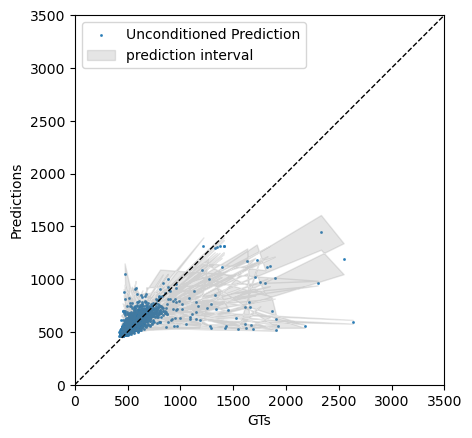

In [44]:
plt.scatter(validpd['arr_time'].tolist(), pred_m,  marker = '.', s=5, alpha=0.8, label='Unconditioned Prediction')
plt.fill_between(validpd['arr_time'].tolist(), err_down, err_up, color='gray', alpha=0.2, label='prediction interval')

plt.xlabel('GTs')
plt.ylabel('Predictions')
plt.axis('scaled')
plt.xlim(0, 3500)
plt.ylim(0, 3500)
plt.axline([0, 0], [3500, 3500], color='black', linewidth=1, linestyle='--')
plt.legend()

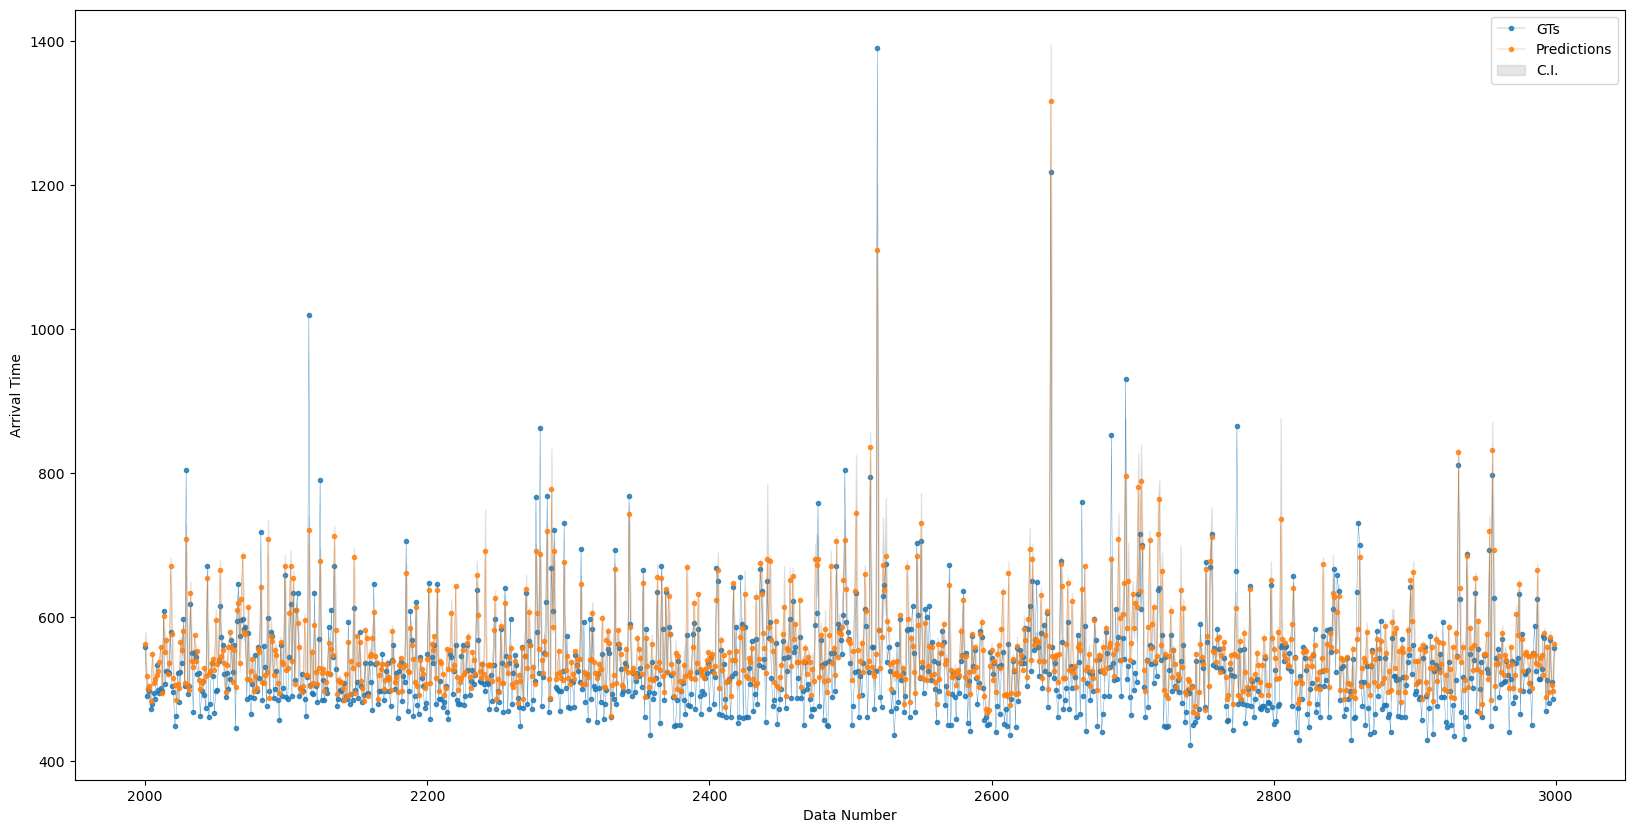

In [45]:
fig, ax= plt.subplots(figsize=(20, 10))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))

st = 2000
end = 3000

_ = range(valid.shape[0])
#plt.scatter(_[st:end], validpd['arr_time'].tolist()[st:end], marker = '.', label='GTs', s=5, alpha=0.8)
plt.plot(_[st:end], validpd['arr_time'].tolist()[st:end], marker = '.', label='GTs', alpha=0.8, linewidth=0.3)

err_down = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_down+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_down - pred_m, err_up-pred_m]
#plt.scatter(_[st:end], pred_m[st:end], marker = '.', label='Predictions', s=5, alpha=0.8)
plt.plot(_[st:end], pred_m[st:end], marker = '.', label='Predictions', linewidth=0.3, alpha=0.8)

plt.fill_between(x[st:end], err_down[st:end], err_up[st:end], color='gray', alpha=0.2, label='C.I.')
plt.legend()
plt.ylabel('Arrival Time')
plt.xlabel('Data Number')
fig.savefig('MLPrediction-Zoom', dpi=300)

#### Feature Importance

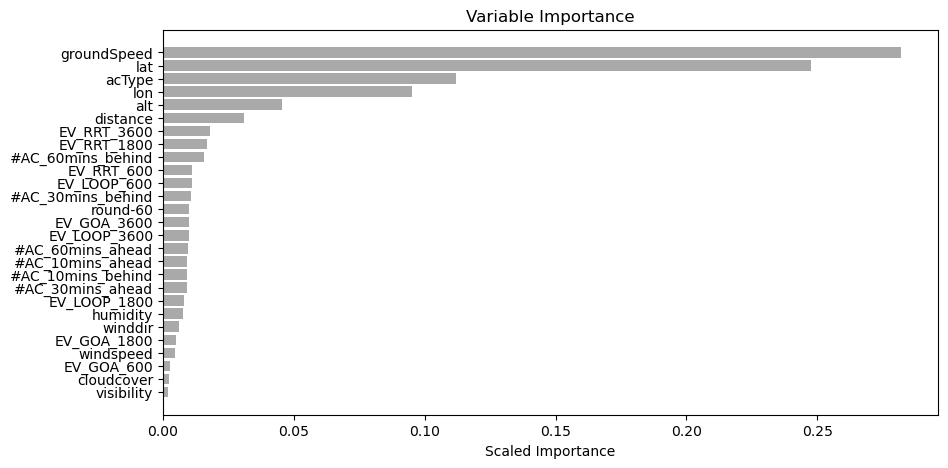

In [46]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = best_model_up._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model_up._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_lower',dpi=300)

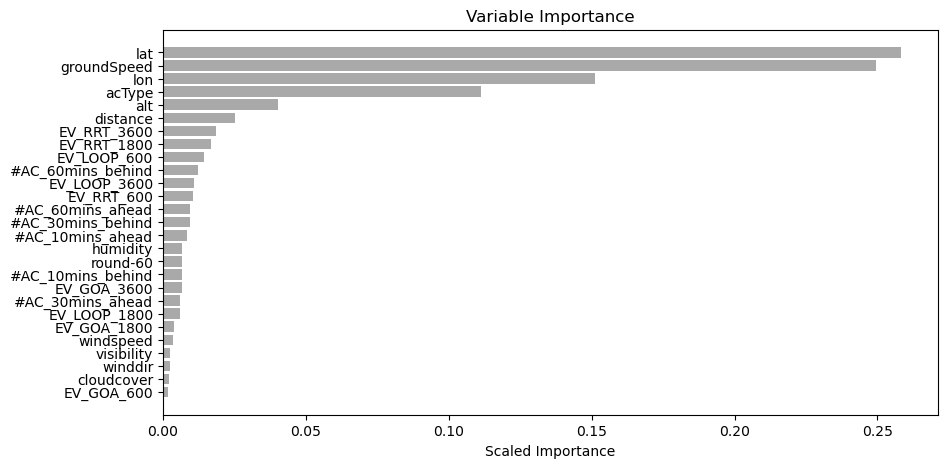

In [47]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = best_model_down._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = best_model_down._model_json['output']['variable_importances']['percentage']

ax.barh(y_pos, scaled_importance, align='center', color='darkgrey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()
fig.savefig('VI_lower',dpi=300)

# Optimization pipeline

In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import Window

myschema = StructType([
        # 1  //track point record type number
        StructField("recType", ShortType(), True),
        # 2  //seconds since midnigght 1/1/70 UTC
        StructField("recTime", StringType(), True),
        StructField("fltKey", LongType(), True),  # 3  //flight key
        # 4  //digit range from 0 to 7
        StructField("bcnCode", IntegerType(), True),
        StructField("cid", IntegerType(), True),  # 5  //computer flight id
        StructField("Source", StringType(), True),  # 6  //source of the record
        StructField("msgType", StringType(), True),  # 7
        StructField("acId", StringType(), True),  # 8  //call sign
        StructField("recTypeCat", StringType(), True),  # 9
        StructField("lat", DoubleType(), True),  # 10
        StructField("lon", DoubleType(), True),  # 11
        StructField("alt", DoubleType(), True),  # 12  //in 100s of feet
        # 13 //digit range from 1 to 10
        StructField("significance", ShortType(), True),
        StructField("latAcc", DoubleType(), True),  # 14
        StructField("lonAcc", DoubleType(), True),  # 15
        StructField("altAcc", DoubleType(), True),  # 16
        StructField("groundSpeed", IntegerType(), True),  # 17 //in knots
        # 18  //in degrees from true north
        StructField("course", DoubleType(), True),
        # 19  //in feet per minute
        StructField("rateOfClimb", DoubleType(), True),
        # 20  //Altitude qualifier (the “B4 character”)
        StructField("altQualifier", StringType(), True),
        # 21  //Altitude indicator (the “C4 character”)
        StructField("altIndicator", StringType(), True),
        # 22  //Track point status (e.g., ‘C’ for coast)
        StructField("trackPtStatus", StringType(), True),
        # 23  //int 0-8 representing the direction of the leader line
        StructField("leaderDir", IntegerType(), True),
        StructField("scratchPad", StringType(), True),  # 24
        # 25 // MSAW Inhibit Indicator (0=not inhibited, 1=inhibited)
        StructField("msawInhibitInd", ShortType(), True),
        StructField("assignedAltString", StringType(), True),  # 26
        StructField("controllingFac", StringType(), True),  # 27
        StructField("controllingSec", StringType(), True),  # 28
        StructField("receivingFac", StringType(), True),  # 29
        StructField("receivingSec", StringType(), True),  # 30
        # 31  // the active control number
        StructField("activeContr", IntegerType(), True),
        # 32  //The primary(previous, controlling, or possible next)controller number
        StructField("primaryContr", IntegerType(), True),
        # 33  //identifies a subset of controller keyboards
        StructField("kybrdSubset", StringType(), True),
        # 34  //identifies a keyboard within the keyboard subsets
        StructField("kybrdSymbol", StringType(), True),
        # 35  //arrival departure status code
        StructField("adsCode", IntegerType(), True),
        # 36  //Operations type (O/E/A/D/I/U)from ARTS and ARTS 3A data
        StructField("opsType", StringType(), True),
        StructField("airportCode", StringType(), True),  # 37
        StructField("trackNumber", IntegerType(), True),  # 38
        StructField("tptReturnType", StringType(), True),  # 39
        StructField("modeSCode", StringType(), True),  # 40
        # 41 //a list of sensor/track number combinations
        StructField("sensorTrackNumberList", StringType(), True),
        # 42 // representing the Ident feature
        StructField("spi", StringType(), True),
        # 43 // indicate the aircraft is within a suppresion volumn area
        StructField("dvs", StringType(), True),
        # 44 // indicate 2 aircraft have the same mode 3a code
        StructField("dupM3a", StringType(), True),
        # 45 //Aircraft Ident entered by pilot
        StructField("tid", StringType(), True),
    ])

spark = SparkSession.builder\
    .appName("Terminal_Area_Flight_Data_Query")\
    .config("spark.driver.memory", "50g")\
    .config("spark.driver.maxResultSize", "50g")\
    .getOrCreate()


date_ls = [20190801]

file_path = f"/media/ypang6/paralab/Research/data/{sector}/"
file_dir = []
for date in date_ls:
    file_names = f'IFF_{sector}_{date}*.csv'
    file_dir.append(glob.glob(file_path+file_names)[0])

df = spark.read.csv(file_dir, header=False, sep=",", schema=myschema)
cols = ['recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed']
df_rec3 = df.select(*cols).filter(df['recType']==3).withColumn("recTime", df['recTime'].cast(IntegerType()))

pdf_rec3 = df_rec3.toPandas()

pdf_rec3['next_acId'] = pdf_rec3['acId'].shift(-1)
pdf_rec3['previous_acId'] = pdf_rec3['acId'].shift(1)
pdf_rec3['init_ac'] = pdf_rec3['acId'] != pdf_rec3['previous_acId']
pdf_rec3['end_ac'] = pdf_rec3['acId'] != pdf_rec3['next_acId']
pdf_rec3.drop(columns=['previous_acId', 'next_acId'])

pdf_rec3.count()

file_path = glob.glob('../data_preprocessing/processed_features_weather/{}*'.format(sector))
pdf3 = pd.concat(map(pd.read_csv, file_path))

23/06/23 00:54:34 WARN Utils: Your hostname, EN4147374UL resolves to a loopback address: 127.0.1.1; using 192.168.1.113 instead (on interface wlx6cfdb9093aff)
23/06/23 00:54:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/06/23 00:54:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


,acId,acType
629,DAL1954,A321
632,DAL1676,MD88
655,EDV3441,CRJ9
663,DAL2212,B712
668,DAL2794,B739
673,DAL2136,MD90
674,DAL1546,A321
675,DAL2028,A321
676,DAL3004,B739


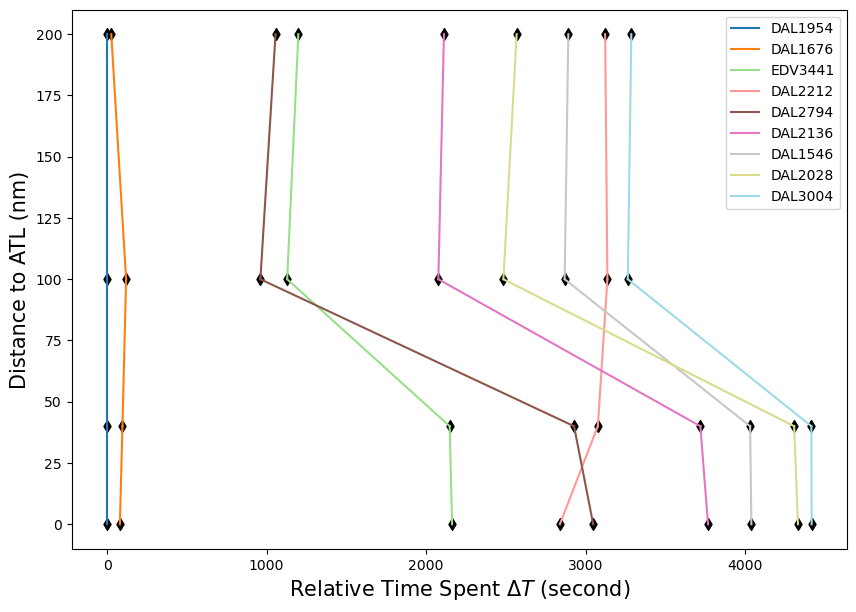

In [49]:
#time_interval = [1564680000, 1564680000+25*60]# 13:20 - 13:36 for case study 1 
time_interval = [1564689600, 1564689600+3600] #16:00 - 16:30 for case study 2
#time_interval = [1564707600, 1564707600+1200] #21:00 - 21:20 for case study 3

busy = pdf3.loc[pdf3['recTime'].between(time_interval[0],time_interval[1])]
busy_runway1 = []
land_t = []

for index, row in busy.iterrows():
    acTr = pdf_rec3.loc[pdf_rec3['acId']==row['acId']]
    end_row = acTr.loc[acTr['end_ac']==True]
    check = end_row.loc[end_row['lat'].between(33.64, 33.65)]
    check = check.loc[check['recTime'].between(time_interval[0],time_interval[1]+3600)]
    if check.empty:
        continue
    busy_runway1.append(row['acId'])
    end_rows = acTr.loc[check.index[0]-20:check.index[0]]
    end_rows = end_rows.loc[end_rows['alt']==check['alt'].values[0]]
    land_t.append(end_rows.head(1)['recTime'].values[0])
    
busy = busy[busy['acId'].isin(busy_runway1)]
busy['land_t'] = land_t

time200 = busy['time200'].copy()
time100 = busy['time100'].copy()
time40 = busy['time40'].copy()
time0 = busy['land_t'].copy()
fig, ax = plt.subplots(figsize=(10, 7))

cmap = plt.cm.get_cmap('tab20', len(time200))
for i, time in enumerate(time200):
    time200_tmp = time-min(time200)
    time100_tmp = time100.values[i]-min(time100)
    time40_tmp = time40.values[i]-min(time40)
    time0_tmp = time0.values[i] - min(time0)

    # ar1 = plt.arrow(time200_tmp, 200, time100_tmp-time200_tmp, -100)
    # ar2 = plt.arrow(time100_tmp, 100, time40_tmp-time100_tmp, -60)
    # ar3 = plt.arrow(time40_tmp, 40, time0_tmp - time40_tmp, -40)
    # ax.add_artist(ar1)
    # ax.add_artist(ar2)
    # ax.add_artist(ar3)
    plt.plot([time200_tmp, time100_tmp], [200, 100], color=cmap(i), label=list(busy['acId'])[i])
    plt.plot([time100_tmp, time40_tmp], [100, 40], color=cmap(i))
    plt.plot([time40_tmp, time0_tmp], [40, 0], color=cmap(i))

    ax.scatter(time200_tmp, 200, marker='d', color='black')
    ax.scatter(time100_tmp, 100, marker='d', color='black')
    ax.scatter(time40_tmp, 40, marker='d', color='black')
    ax.scatter(time0_tmp, 0, marker='d', color = 'black')
plt.legend()
plt.xlabel('Relative Time Spent $\Delta T$ (second)', fontsize=15)
plt.ylabel('Distance to ATL (nm)', fontsize=15)
plt.savefig(f'truth_{date}', dpi=300)


slice_data = busy
slice_data[['acId', 'acType']]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


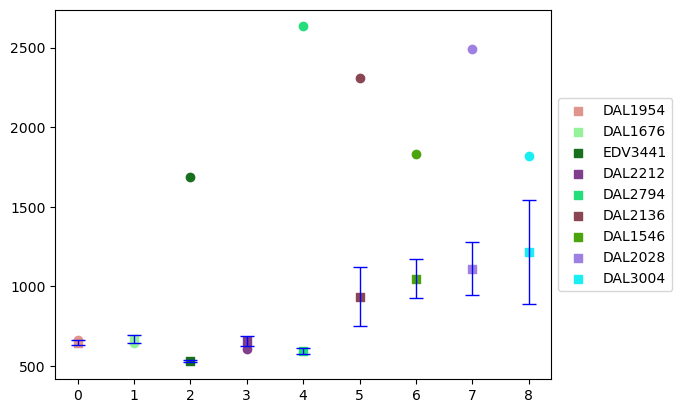

In [50]:
slice_data_hf = h2o.H2OFrame(slice_data)
slice_pred_up = best_model_up.predict(slice_data_hf)
slice_pred_down = best_model_down.predict(slice_data_hf)

true_data = slice_data['arr_time'].values
err_pred_down = np.array(h2o.as_list(slice_pred_down)['predict'])
err_pred_up = np.array(h2o.as_list(slice_pred_up)['predict'])
slice_pred = (err_pred_down + err_pred_up)/2
_ = range(len(slice_pred))
yerror = [slice_pred - err_pred_down, err_pred_up-slice_pred]
plt.errorbar(_, slice_pred, yerr=yerror, fmt='b', elinewidth=1, capsize=5, barsabove=True, ls='none')

marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
for i in range(len(true_data)):
    rgb = np.random.rand(3,)
    plt.scatter(_[i], slice_pred[i], marker='s', color=[rgb], label = slice_data['acId'].values[i])
    plt.scatter(_[i], true_data[i], marker='o', color = [rgb])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))


In [51]:
(err_pred_up - err_pred_down)/2

array([  13.39449202,  -23.73722485,   -7.02473612,  -29.06388416,
        -17.78786275, -184.75852143, -122.62145217, -166.26676446,
       -325.97091753])

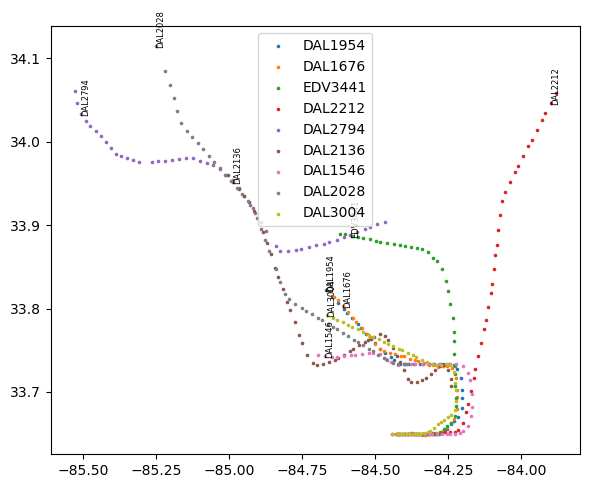

In [52]:
plt.figure(figsize=(6,5))
for index, row in slice_data.iterrows():
    id = row['acId']
    tr = pdf_rec3.loc[pdf_rec3['acId']==id]

    if id == 'DAL2794':
        start_idx = tr.index[0]
        interval_idx = tr['recTime'].diff().argmax()
        tr = tr.iloc[interval_idx:]

    time = row['recTime']
    dest = row['Dest']
    tr = tr.loc[tr['recTime'].between(time, time+3000)]
    plt.scatter(tr['lon'][-50:], tr['lat'][-50:], marker = '.', s=10, label=id)
    j = np.random.randint(len(slice_data))
    plt.text(tr['lon'].values[-50+j//2],tr['lat'].values[-50+j//2], id, rotation='vertical',fontsize=6)
    #plt.scatter(airportsCoord[dest][1], airportsCoord[dest][0], marker = '*', color='r', s = 200)
    #for index, row in tr.iterrows():
        #distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
        #if distance2airport<74080:
            #plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
            #break
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig('landing_trj.png', dpi=300)

In [53]:
slice_data['acType']

629    A321
632    MD88
655    CRJ9
663    B712
668    B739
673    MD90
674    A321
675    A321
676    B739
Name: acType, dtype: object

In [54]:
from pyomo.environ import *
import numpy as np
import sys
from DistributionATSP import Distribution_ATSP
from scipy.stats import norm
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

runway3 = busy_runway1

def time_space(threshold, sd1, sd2):
    return threshold - norm.ppf(q = Pc, loc = 0,scale = np.sqrt(sd1**2 + sd2**2))

Pc = 0.1
UB = [100000]
LB = [0]
tt = [0]
items = ['acId', 'threshold', 'mean', 'sd', 'uperBound', 'lowerBound']
ac = pd.DataFrame([], columns=items)
ac['acId'] = runway3
#ac['mean']= runway3_arr_time
ac.loc[:,'threshold'] = 64

r3_time = slice_data['recTime'].copy()
r3_time -= min(r3_time)
r3_time.values


#for id in slice_data['acId'].values:
    #check.append(id in runway3)
r3_pred = np.array(slice_pred)
#ac['mean'] = slice_data[check]['arr_time'].values

ac['mean'] = r3_pred + r3_time.values
ac['sd'] = abs(np.array(err_pred_up) - r3_pred)
ac['lowerBound'] = ac['mean'] - 60
ac['uperBound'] = ac['mean'] + 600
ac.loc[ac[ac['lowerBound']<0].index, 'lowerBound']=0

ac['acType'] = slice_data['acType'].values

In [55]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound,acType
0,DAL1954,64,647.315535,13.394492,1247.315535,587.315535,A321
1,DAL1676,64,789.729494,23.737225,1389.729494,729.729494,MD88
2,EDV3441,64,1657.855824,7.024736,2257.855824,1597.855824,CRJ9
3,DAL2212,64,3793.599522,29.063884,4393.599522,3733.599522,B712
4,DAL2794,64,1556.894021,17.787863,2156.894021,1496.894021,B739
5,DAL2136,64,3012.101810,184.758521,3612.101810,2952.101810,MD90
6,DAL1546,64,3915.772477,122.621452,4515.772477,3855.772477,A321
7,DAL2028,64,3596.353808,166.266764,4196.353808,3536.353808,A321
8,DAL3004,64,4482.082746,325.970918,5082.082746,4422.082746,B739


In [56]:
r3_pred

array([ 647.31553504,  670.72949356,  528.85582358,  656.59952196,
        595.89402058,  935.10180975, 1046.77247745, 1111.35380813,
       1217.08274649])

In [57]:
runway3

['DAL1954',
 'DAL1676',
 'EDV3441',
 'DAL2212',
 'DAL2794',
 'DAL2136',
 'DAL1546',
 'DAL2028',
 'DAL3004']

In [58]:
ac=ac.drop('acType', axis=1)
runway3 = slice_data['acId'].values
max_num = min(len(runway3), 9)

gap = (len(runway3) - max_num) // 2
ac_runway3 = runway3[gap:-gap]
ac_runway3 = runway3[:max_num]


check2 = []
for id in ac['acId'].values:
    check2.append(id in ac_runway3)
ac = ac[check2]
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL1954,64,647.315535,13.394492,1247.315535,587.315535
1,DAL1676,64,789.729494,23.737225,1389.729494,729.729494
2,EDV3441,64,1657.855824,7.024736,2257.855824,1597.855824
3,DAL2212,64,3793.599522,29.063884,4393.599522,3733.599522
4,DAL2794,64,1556.894021,17.787863,2156.894021,1496.894021
5,DAL2136,64,3012.101810,184.758521,3612.101810,2952.101810
6,DAL1546,64,3915.772477,122.621452,4515.772477,3855.772477
7,DAL2028,64,3596.353808,166.266764,4196.353808,3536.353808
8,DAL3004,64,4482.082746,325.970918,5082.082746,4422.082746


In [59]:
ac['acId'].values

array(['DAL1954', 'DAL1676', 'EDV3441', 'DAL2212', 'DAL2794', 'DAL2136',
       'DAL1546', 'DAL2028', 'DAL3004'], dtype=object)

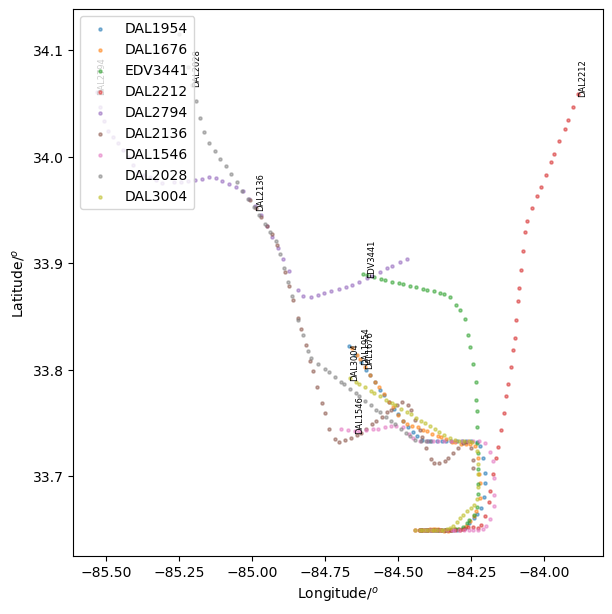

In [60]:
plt.figure(figsize=(6,6))

for index, row in slice_data.iterrows():
    id = row['acId']
    if id in ac_runway3:
        tr = pdf_rec3.loc[pdf_rec3['acId']==id]
        if id == 'DAL2794':
            start_idx = tr.index[0]
            interval_idx = tr['recTime'].diff().argmax()
            tr = tr.iloc[interval_idx:]

        time = row['recTime']
        dest = row['Dest']
        tr = tr.loc[tr['recTime'].between(time,time+3000)] # 3000 for case I, 10000 for case 2
        plt.scatter(tr['lon'][-50:], tr['lat'][-50:], marker = 'o', s=5, alpha=0.5, label=id)

        j = np.random.randint(len(slice_data))
        plt.text(tr['lon'].values[-50+j//2], tr['lat'].values[-50+j//2], id, rotation='vertical',fontsize=6)

plt.legend(loc='upper left')
plt.tight_layout()
plt.xlabel('Longitude/$^o$')
plt.ylabel('Latitude/$^o$')
plt.savefig('landing_trj_1.png', dpi=300)


In [61]:
ac = ac.reset_index(drop=True)
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL1954,64,647.315535,13.394492,1247.315535,587.315535
1,DAL1676,64,789.729494,23.737225,1389.729494,729.729494
2,EDV3441,64,1657.855824,7.024736,2257.855824,1597.855824
3,DAL2212,64,3793.599522,29.063884,4393.599522,3733.599522
4,DAL2794,64,1556.894021,17.787863,2156.894021,1496.894021
5,DAL2136,64,3012.101810,184.758521,3612.101810,2952.101810
6,DAL1546,64,3915.772477,122.621452,4515.772477,3855.772477
7,DAL2028,64,3596.353808,166.266764,4196.353808,3536.353808
8,DAL3004,64,4482.082746,325.970918,5082.082746,4422.082746


In [62]:
from DistributionATSP import Distribution_ATSP

tt = np.array([0])
tt = np.append(tt, np.array(ac['mean'].tolist()))
num_ac = len(ac_runway3)
for index, row in ac.iterrows():
    LB.append(row['lowerBound'])
    UB.append(row['uperBound'])
    tt_temp = [0]
    for ii in range(num_ac):
        if index == ii:
            space = 0
        else:
            space = time_space(row['threshold'], row['sd'], ac.loc[ii]['sd']) 
        tt_temp.append(space)
    tt=np.vstack((tt, np.array(tt_temp)))

N = num_ac
ccc = Distribution_ATSP(UB, LB, N, tt)
model = ccc.set_model()

solver = SolverFactory('glpk')
solution = solver.solve(model, tee=True)
result_time = np.zeros(N)
for i in range(N):
    result_time[i] = model.t[i+2].value
sort_index = np.argsort(result_time)
sort_time = np.sort(result_time)
sort_index
sort_time

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpp83ay4nc.glpk.raw --wglp /tmp/tmp855bbkwn.glpk.glp --cpxlp
 /tmp/tmpdafogm0q.pyomo.lp
Reading problem data from '/tmp/tmpdafogm0q.pyomo.lp'...
/tmp/tmpdafogm0q.pyomo.lp:1414: warning: lower bound of variable 'x12' redefined
/tmp/tmpdafogm0q.pyomo.lp:1414: warning: upper bound of variable 'x12' redefined
238 rows, 111 columns, 580 non-zeros
100 integer variables, all of which are binary
1514 lines were read
Writing problem data to '/tmp/tmp855bbkwn.glpk.glp'...
1172 lines were written
GLPK Integer Optimizer 5.0
238 rows, 111 columns, 580 non-zeros
100 integer variables, all of which are binary
Preprocessing...
9 constraint coefficient(s) were reduced
78 rows, 60 columns, 236 non-zeros
50 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.308e+03  ratio =  1.308e+03
GM: min|aij| =  5.956e-01  max|aij| =  1.679e+00  ratio =  2.819e+00
EQ: min|aij| =  3.56

array([ 789.72949356,  888.65896284, 1597.85582358, 1686.36514057,
       2952.10180975, 3536.35380813, 3816.66417198, 4042.16372143,
       4552.49164777])

In [63]:
ttpd=pd.DataFrame(tt)
ttpd

,0,1,2,3,4,5,6,7,8,9
0,0.0,647.315535,789.729494,1657.855824,3793.599522,1556.894021,3012.101810,3915.772477,3596.353808,4482.082746
1,0.0,0.000000,98.929469,83.383201,105.012089,92.536343,301.398991,222.080479,277.769752,482.101070
2,0.0,98.929469,0.000000,95.724621,112.090898,102.014023,302.723740,224.063053,279.239982,482.854686
3,0.0,83.383201,95.724621,0.000000,102.319384,88.509317,300.948655,221.403372,277.269526,481.845532
4,0.0,105.012089,112.090898,102.319384,0.000000,107.669091,303.689273,225.499549,280.310364,483.405736
5,0.0,92.536343,102.014023,88.509317,107.669091,0.000000,301.872401,222.790541,278.295369,482.370055
6,0.0,301.398991,302.723740,300.948655,303.689273,301.872401,0.000000,348.180214,382.538009,544.184820
7,0.0,222.080479,224.063053,221.403372,225.499549,222.790541,348.180214,0.000000,328.759551,510.327926
8,0.0,277.769752,279.239982,277.269526,280.310364,278.295369,382.538009,328.759551,0.000000,532.952755
9,0.0,482.101070,482.854686,481.845532,483.405736,482.370055,544.184820,510.327926,532.952755,0.000000


In [64]:
sort_time

array([ 789.72949356,  888.65896284, 1597.85582358, 1686.36514057,
       2952.10180975, 3536.35380813, 3816.66417198, 4042.16372143,
       4552.49164777])

In [65]:
ac = ac.reindex(sort_index)
sort_index

array([1, 0, 2, 4, 5, 7, 3, 6, 8])

In [66]:
marker = ['o','s','v','^','D','d','p','P', 'x']
#marker = ['o','s','v','^','D','d','p','P']
#marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
color = np.random.rand(9, 3)
#ac_indicator = pd.DataFrame()
ac_indicator = ac[['acId']].copy()
ac_indicator['marker'] = marker
ac_indicator['color'] = color.tolist()
ac_indicator

,acId,marker,color
1,DAL1676,o,"[0.7671776044024875, 0.6677174584189998, 0.7095548962506234]"
0,DAL1954,s,"[0.04304445601350637, 0.2933714980754021, 0.5230836332319945]"
2,EDV3441,v,"[0.6774547495450212, 0.6035116224333704, 0.8200394028428936]"
4,DAL2794,^,"[0.012926336943949956, 0.17075266485769258, 0.3898897731738078]"
5,DAL2136,D,"[0.34906167902749363, 0.2611076508848744, 0.7735889038047713]"
7,DAL2028,d,"[0.7792066168613724, 0.5489329565343147, 0.6371401696882335]"
3,DAL2212,p,"[0.2310885875025771, 0.7255208644286572, 0.7860622482732752]"
6,DAL1546,P,"[0.1176116324978086, 0.1969745755574639, 0.1313627127635374]"
8,DAL3004,x,"[0.27666790695353294, 0.10034159204742055, 0.9371177394983653]"


In [67]:
land_time = []
time_40 = []
time_100 = []
time_200 = []
ac_runway3 = ac_indicator['acId'].values
for id in ac_runway3:
    land_time.append(slice_data.loc[slice_data['acId']==id]['land_t'].values[0])
    time_40.append(slice_data.loc[slice_data['acId']==id]['time40'].values[0])
    time_100.append(slice_data.loc[slice_data['acId']==id]['time100'].values[0])
    time_200.append(slice_data.loc[slice_data['acId']==id]['time200'].values[0])

ac_indicator['land_time'] = land_time
ac_indicator['time40'] = time_40
ac_indicator['time100'] = time_100
ac_indicator['time200'] = time_200
ac_indicator['sort_time'] = sort_time
#ac_indicator['sort_time'] = np.zeros(ac_indicator.shape[0])
#for i in range(ac_indicator.shape[0]):
#    ac_indicator.loc[i,'sort_time'] = sort_time[i]
ac_indicator

,acId,marker,color,land_time,time40,time100,time200,sort_time
1,DAL1676,o,"[0.7671776044024875, 0.6677174584189998, 0.7095548962506234]",1564691405,1564690545,1564689902,1564688941,789.729494
0,DAL1954,s,"[0.04304445601350637, 0.2933714980754021, 0.5230836332319945]",1564691325,1564690449,1564689783,1564688915,888.658963
2,EDV3441,v,"[0.6774547495450212, 0.6035116224333704, 0.8200394028428936]",1564693488,1564692597,1564690912,1564690114,1597.855824
4,DAL2794,^,"[0.012926336943949956, 0.17075266485769258, 0.3898897731738078]",1564694373,1564693377,1564690744,1564689971,1686.365141
5,DAL2136,D,"[0.34906167902749363, 0.2611076508848744, 0.7735889038047713]",1564695093,1564694169,1564691860,1564691027,2952.101810
7,DAL2028,d,"[0.7792066168613724, 0.5489329565343147, 0.6371401696882335]",1564695657,1564694757,1564692268,1564691483,3536.353808
3,DAL2212,p,"[0.2310885875025771, 0.7255208644286572, 0.7860622482732752]",1564694164,1564693526,1564692920,1564692038,3816.664172
6,DAL1546,P,"[0.1176116324978086, 0.1969745755574639, 0.1313627127635374]",1564695365,1564694481,1564692652,1564691807,4042.163721
8,DAL3004,x,"[0.27666790695353294, 0.10034159204742055, 0.9371177394983653]",1564695743,1564694865,1564693048,1564692202,4552.491648


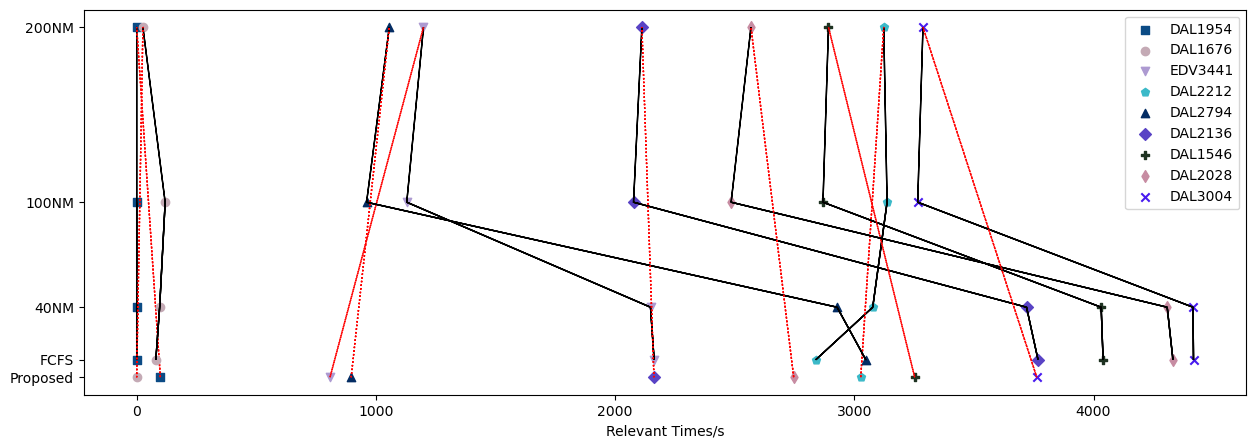

In [68]:
fig, ax = plt.subplots(figsize = (15,5))
for i in range(len(ac_runway3)):
    plt.scatter(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time100'][i]-min(ac_indicator['time100']), 100, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time40'][i]-min(ac_indicator['time40']), 40, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['land_time'][i]-min(ac_indicator['land_time']), 10, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['sort_time'][i]-min(ac_indicator['sort_time']), 0, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i], label = ac_indicator['acId'][i])
    ar0 = plt.arrow(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, ac_indicator['time100'][i]-min(ac_indicator['time100']) - (ac_indicator['time200'][i]-min(ac_indicator['time200'])), -100)
    ar1 = plt.arrow(ac_indicator['time100'][i]-min(ac_indicator['time100']), 100, ac_indicator['time40'][i]-min(ac_indicator['time40']) - (ac_indicator['time100'][i]-min(ac_indicator['time100'])), -60)
    ar2 = plt.arrow(ac_indicator['time40'][i]-min(ac_indicator['time40']), 40, ac_indicator['land_time'][i]-min(ac_indicator['land_time']) - (ac_indicator['time40'][i]-min(ac_indicator['time40'])), -30)                
    ar3 = plt.arrow(ac_indicator['time200'][i]-min(ac_indicator['time200']), 200, ac_indicator['sort_time'][i]-min(ac_indicator['sort_time']) - (ac_indicator['time200'][i]-min(ac_indicator['time200'])),-200,linestyle=':', color = 'r')

    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
    
plt.legend(loc='upper right')
plt.xlabel('Relevant Times/s')

y = [0, 10, 40, 100, 200]
yticks = ['Proposed', 'FCFS', '40NM', '100NM', '200NM']
plt.yticks(y, yticks, rotation = 'horizontal')
plt.savefig('absolute_time_results.png', dpi=300)

In [69]:
first_acTime = min(ac_indicator['land_time'])
first_acTime

1564691325

/tmp/ipykernel_784554/2351838000.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


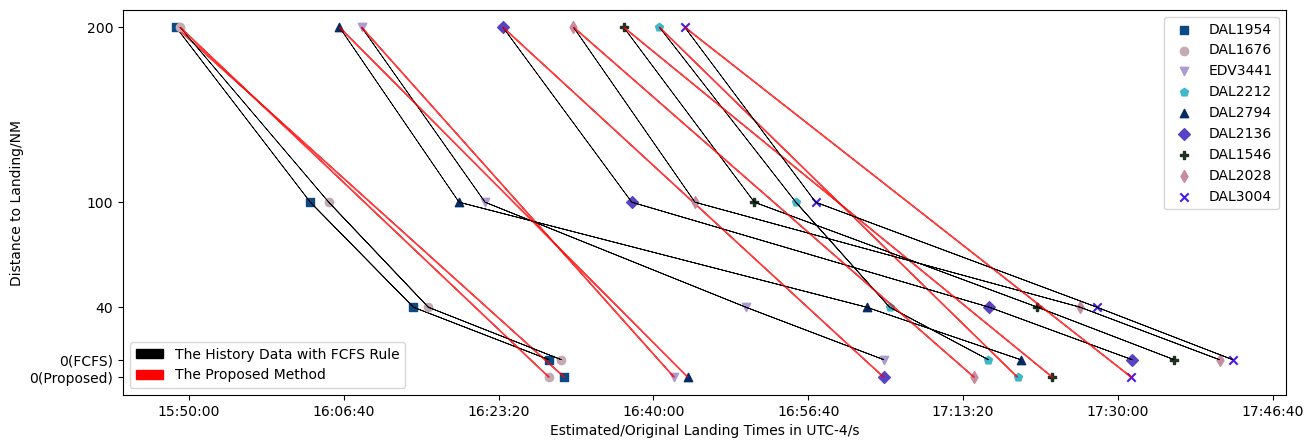

In [70]:
from datetime import timedelta
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize = (15,5))
bias = min(ac_indicator['land_time']) - min(ac_indicator['sort_time'])


for i in range(len(ac_runway3)):
    plt.scatter(ac_indicator['time200'][i], 200, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time100'][i], 100, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['time40'][i], 40, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])
    plt.scatter(ac_indicator['land_time'][i], 10, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i])

    plt.scatter(ac_indicator['sort_time'][i] + bias, 0, color = ac_indicator['color'][i], marker = ac_indicator['marker'][i], label = ac_indicator['acId'][i])
    
    ar0 = plt.arrow(ac_indicator['time200'][i], 200, ac_indicator['time100'][i] - ac_indicator['time200'][i], -100, linewidth = 0.5)
    ar1 = plt.arrow(ac_indicator['time100'][i], 100, ac_indicator['time40'][i] - ac_indicator['time100'][i], -60, linewidth = 0.5)
    ar2 = plt.arrow(ac_indicator['time40'][i], 40, ac_indicator['land_time'][i]- ac_indicator['time40'][i], -30, linewidth = 0.5)                
    ar3 = plt.arrow(ac_indicator['time200'][i], 200, ac_indicator['sort_time'][i] + bias - ac_indicator['time200'][i],-200,linestyle='-', color = 'red', alpha=0.5)

    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
    
plt.xlabel('Estimated/Original Landing Times in UTC-4/s')
l1 = plt.legend()
y = [0, 10, 40, 100, 200]
yticks = ['0(Proposed)', '0(FCFS)', '40', '100', '200']
plt.yticks(y, yticks, rotation = 'horizontal')
plt.ylabel('Distance to Landing/NM')

xtickslocs = ax.get_xticks()
xticks = [str(x).split("+")[0].split(" ")[-1] for x in pd.to_datetime(xtickslocs, unit='s', utc='True') - timedelta(hours=4)]
ax.set_xticklabels(xticks)
#plt.xticks(rotation=45)

ax.add_artist(l1)

red_patch = mpatches.Patch(color='red', label='The Proposed Method')
blue_patch = mpatches.Patch(color='black', label='The History Data with FCFS Rule')
plt.legend(handles=[blue_patch,red_patch], loc='lower left')

fig.savefig('result-1.png', dpi=300)


In [71]:
from datetime import timedelta
[str(x) for x in pd.to_datetime(ac_indicator['sort_time'] + bias, unit='s', utc='True') - timedelta(hours=4)]

['2019-08-01 16:28:45+00:00',
 '2019-08-01 16:30:23.929469184+00:00',
 '2019-08-01 16:42:13.126329856+00:00',
 '2019-08-01 16:43:41.635646976+00:00',
 '2019-08-01 17:04:47.372316160+00:00',
 '2019-08-01 17:14:31.624314624+00:00',
 '2019-08-01 17:19:11.934678272+00:00',
 '2019-08-01 17:22:57.434227712+00:00',
 '2019-08-01 17:31:27.762153984+00:00']

In [90]:
# landing time improvement
t_df_new = ac_indicator['sort_time'].tail(1).values - ac_indicator['sort_time'].head(1).values
t_df_old = ac_indicator['land_time'].tail(1).values - ac_indicator['land_time'].head(1).values
perc = (t_df_old - t_df_new)/t_df_old
print(f'Total landing time reduced by {perc} in this case study')

Total landing time reduced by [0.13260439] in this case study
